# Projeto FlightOnTime: Modelo Preditivo de Atrasos (MVP)

**Autor:** Time de Data Science  
**Contexto:** Hackathon FlightOnTime  
**Versão:** 1.0.0 (Release Candidate)

---



#1. Definição do Problema e Escopo

### 1.1 Visão Geral
O setor de aviação civil enfrenta desafios constantes relacionados à pontualidade. Atrasos geram custos operacionais em cascata para as companhias aéreas e insatisfação crítica para os passageiros. O projeto **FlightOnTime** visa mitigar esses problemas através de uma solução preditiva leve e integrada.

### 1.2 Objetivo do Negócio
Desenvolver um motor de inteligência artificial capaz de estimar a probabilidade de atraso de um voo no momento de sua consulta. A solução opera como um microserviço, permitindo alertas antecipados de risco operacional.


#2. Premissas do MVP
Para garantir a viabilidade da integração com a API Java dentro do prazo do Hackathon, adotamos as seguintes diretrizes de arquitetura:
1.  **Zero Dependência Externa:** O modelo não consulta bancos de dados históricos em tempo real, eliminando latência.
2.  **Inputs Disponíveis:** As predições utilizam apenas os dados contidos no bilhete aéreo (Companhia, Rota, Data/Hora).
3.  **Foco na Detecção:** Dada a natureza crítica dos atrasos, o modelo prioriza a **Sensibilidade (Recall)** para minimizar falsos negativos (deixar de avisar um atraso real).

---

In [23]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

# Modelo Final
from catboost import CatBoostClassifier

# Ferramentas de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configurações globais de visualização
plt.style.use('ggplot')
%matplotlib inline

#3. Coleta e Tratamento de Dados (ETL)
O dataset base contém registros históricos de operações aéreas no Brasil. Nesta etapa, realizamos a limpeza e a filtragem para garantir a consistência do treinamento.




##3.1 Carregamento e Filtragem

In [3]:
# ==============================================================================
# 3.1 CARREGAMENTO E FILTRAGEM
# ==============================================================================

# 1. Carregamento do dataset
try:
    df = pd.read_csv('/content/BrFlights2.csv', encoding='latin1', low_memory=False)
    print(f" Dataset carregado. Registros Brutos: {df.shape[0]:,}")
except FileNotFoundError:
    print("Erro crítico: Dataset não encontrado. Faça o upload do CSV.")

# 2. Remoção de Duplicados (Limpeza Inicial)
duplicados = df.duplicated().sum()
if duplicados > 0:
    print(f" Encontrados {duplicados:,} registros duplicados. Removendo...")
    df.drop_duplicates(inplace=True)
    print(f"✅ Registros Únicos Restantes: {df.shape[0]:,}")
else:
    print("✅ Nenhum registro duplicado encontrado.")

# 3. Informações Gerais
print("\n--- Info do Dataset ---")
df.info()

print("\n--- Amostra dos Dados ---")
display(df.head())

# 4. Verificação de Período
# Convertemos apenas para visualizar o range de datas
print(f"\n Período dos Dados: de {df['Partida.Prevista'].min()} até {df['Partida.Prevista'].max()}")

 Dataset carregado. Registros Brutos: 2,542,519
 Encontrados 498 registros duplicados. Removendo...
✅ Registros Únicos Restantes: 2,542,021

--- Info do Dataset ---
<class 'pandas.core.frame.DataFrame'>
Index: 2542021 entries, 0 to 2542518
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Voos                  object 
 1   Companhia.Aerea       object 
 2   Codigo.Tipo.Linha     object 
 3   Partida.Prevista      object 
 4   Partida.Real          object 
 5   Chegada.Prevista      object 
 6   Chegada.Real          object 
 7   Situacao.Voo          object 
 8   Codigo.Justificativa  object 
 9   Aeroporto.Origem      object 
 10  Cidade.Origem         object 
 11  Estado.Origem         object 
 12  Pais.Origem           object 
 13  Aeroporto.Destino     object 
 14  Cidade.Destino        object 
 15  Estado.Destino        object 
 16  Pais.Destino          object 
 17  LongDest              float64
 18  LatDest               

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,...,Estado.Origem,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig
0,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-30T08:58:00Z,2016-01-30T08:58:00Z,2016-01-30T10:35:00Z,2016-01-30T10:35:00Z,Realizado,NaN,Afonso Pena,...,PR,Brasil,Salgado Filho,Porto Alegre,RS,Brasil,-51.175381,-29.993473,-49.172481,-25.532713
1,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-13T12:13:00Z,2016-01-13T12:13:00Z,2016-01-13T21:30:00Z,2016-01-13T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
2,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-29T12:13:00Z,2016-01-29T12:13:00Z,2016-01-29T21:30:00Z,2016-01-29T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
3,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-19T12:13:00Z,2016-01-18T12:03:00Z,2016-01-19T21:30:00Z,2016-01-18T20:41:00Z,Realizado,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
4,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-30T12:13:00Z,2016-01-30T12:13:00Z,2016-01-30T21:30:00Z,2016-01-30T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473



 Período dos Dados: de 2015-01-01T00:00:00Z até 2017-08-01T08:45:00Z


In [4]:
# RELATÓRIO DE QUALIDADE DOS DADOS
# Vamos construir um relatório automático para decidir quais colunas manter e quais descartar

info_qualidade = []

for col in df.columns:
    # Captura um exemplo não nulo para inspeção do conteúdo
    exemplo = df[col].dropna().iloc[0] if df[col].notnull().any() else "Tudo Nulo"

    info_qualidade.append({
        'Coluna': col,
        'Tipo Dado': df[col].dtype,
        'Total Nulos': df[col].isnull().sum(),
        '% Nulos': round((df[col].isnull().sum() / len(df)) * 100, 2),
        'Valores Únicos': df[col].nunique(),
        'Exemplo Real': exemplo
    })

# Conversão para DataFrame para melhor visualização
df_qualidade = pd.DataFrame(info_qualidade).sort_values(by='% Nulos', ascending=False)

print(f"Total de Linhas: {len(df):,}")
print(f"Total de Colunas: {len(df.columns)}")
print("-" * 80)
display(df_qualidade)

Total de Linhas: 2,542,021
Total de Colunas: 21
--------------------------------------------------------------------------------


,Coluna,Tipo Dado,Total Nulos,% Nulos,Valores Únicos,Exemplo Real
8,Codigo.Justificativa,object,1509803,59.39,41,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO
6,Chegada.Real,object,289188,11.38,881986,2016-01-30T10:35:00Z
4,Partida.Real,object,289188,11.38,857132,2016-01-30T08:58:00Z
0,Voos,object,0,0.00,6257,AAL - 203
1,Companhia.Aerea,object,0,0.00,56,AMERICAN AIRLINES INC
3,Partida.Prevista,object,0,0.00,738010,2016-01-30T08:58:00Z
2,Codigo.Tipo.Linha,object,0,0.00,3,Internacional
5,Chegada.Prevista,object,0,0.00,779401,2016-01-30T10:35:00Z
7,Situacao.Voo,object,0,0.00,2,Realizado
9,Aeroporto.Origem,object,0,0.00,189,Afonso Pena


##3.2 Engenharia de Features e Limpeza Avançada

Nesta etapa, realizamos transformações críticas para enriquecer os dados e garantir que o modelo não tenha acesso a informações privilegiadas ("Data Leakage").

### 1. Enriquecimento: Cálculo de Distância (Georreferenciamento)
O contrato da API prevê o recebimento da **distância do voo** (`distancia_km`), uma variável física determinante para a gestão de atrasos (voos longos possuem dinâmicas diferentes de pontes aéreas curtas).
* **Ação:** Utilizamos as coordenadas geográficas (Latitude/Longitude) de origem e destino para calcular a distância geodésica precisa através da **Fórmula de Haversine**.

### 2. Higienização e Prevenção de Data Leakage
Para garantir um modelo robusto e realista, removemos colunas que não estarão disponíveis no momento da predição:
* **`Codigo.Justificativa`:** Esta informação é gerada apenas *após* a confirmação do atraso. Mantê-la faria com que o modelo "lesse o futuro", invalidando a predição.
* **`Voos` (Número do Voo):** Removemos o identificador específico para evitar *overfitting* (o modelo decorar um voo específico), forçando-o a aprender o padrão da **`Companhia.Aerea`** (que foi mantida e renomeada).
* **Dados Redundantes:** Removemos coordenadas e nomes de cidades/estados, pois já foram convertidos em distância ou estão representados pelos códigos dos aeroportos.

### 3. Definição do Target
Calculamos o atraso real em minutos e aplicamos a regra de negócio do MVP:
* **Target 1 (Atrasado):** Atrasos superiores a 15 minutos.
* **Target 0 (Pontual):** Demais casos.

In [5]:
# ==============================================================================
# 3.2 ENGENHARIA DE FEATURES, LIMPEZA E OUTLIERS
# ==============================================================================

# 1. CÁLCULO DE DISTÂNCIA (Feature Engineering)
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(res, 2)

print("Calculando distância entre aeroportos...")
df['distancia_km'] = haversine_distance(
    df['LatOrig'], df['LongOrig'],
    df['LatDest'], df['LongDest']
)

# 2. SELEÇÃO DE COLUNAS
cols_a_eliminar = [
    'Codigo.Justificativa', 'Codigo.Tipo.Linha', 'Voos',
    'Cidade.Origem', 'Estado.Origem', 'Pais.Origem',
    'Cidade.Destino', 'Estado.Destino', 'Pais.Destino',
    'LongDest', 'LatDest', 'LongOrig', 'LatOrig',
    'Situacao.Voo'
]
cols_existentes = [c for c in cols_a_eliminar if c in df.columns]
df_clean = df.drop(columns=[c for c in cols_existentes if c != 'Situacao.Voo']).copy()

# 3. FILTRAGEM BÁSICA
print(f"Linhas antes da filtragem: {len(df_clean):,}")

# Apenas voos realizados
df_clean = df_clean[df['Situacao.Voo'] == 'Realizado']
if 'Situacao.Voo' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Situacao.Voo'])

# Renomear
df_clean.rename(columns={
    'Companhia.Aerea': 'companhia',
    'Aeroporto.Origem': 'origem',
    'Aeroporto.Destino': 'destino'
}, inplace=True)

# 4. CONVERSÃO DE DATAS (CRÍTICO: Converter TODAS as 4 datas)
cols_datas = ['Partida.Prevista', 'Partida.Real', 'Chegada.Prevista', 'Chegada.Real']
for col in cols_datas:
    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

# Remover nulos gerados pela conversão
df_clean = df_clean.dropna(subset=['Partida.Prevista', 'Partida.Real', 'Chegada.Real', 'distancia_km'])

# 5. CÁLCULO DE ATRASO E DURAÇÃO
df_clean['delay_minutes'] = (df_clean['Partida.Real'] - df_clean['Partida.Prevista']).dt.total_seconds() / 60
# Duração é necessária para validar se o voo faz sentido físico
df_clean['duration_minutes'] = (df_clean['Chegada.Real'] - df_clean['Partida.Real']).dt.total_seconds() / 60

# 6. REMOÇÃO DE OUTLIERS (SANEAMENTO)
print("Aplicando filtros de consistência...")

# Regra A: Voo com duração negativa ou zero (Impossível)
mask_duracao = df_clean['duration_minutes'] > 0
# Regra B: Atraso maior que 24h (1440min) ou adiantamento > 1h (-60min)
mask_delay = (df_clean['delay_minutes'] > -60) & (df_clean['delay_minutes'] < 1440)

df_clean = df_clean[mask_duracao & mask_delay].copy()

# 7. DEFINIÇÃO DO TARGET
# Target (1 = Atraso > 15 min)
df_clean['target'] = np.where(df_clean['delay_minutes'] > 15, 1, 0)

# Ordenação final
df_clean = df_clean.sort_values('Partida.Prevista').reset_index(drop=True)

print(f"✅ Linhas após limpeza e saneamento: {len(df_clean):,}")
print("-" * 50)
display(df_clean[['companhia', 'origem', 'destino', 'distancia_km', 'delay_minutes', 'target']].head())

Calculando distância entre aeroportos...
Linhas antes da filtragem: 2,542,021
Aplicando filtros de consistência...
✅ Linhas após limpeza e saneamento: 2,238,484
--------------------------------------------------


,companhia,origem,destino,distancia_km,delay_minutes,target
0,GOL,Guarulhos - Governador Andre Franco Montoro,Zumbi Dos Palmares,1920.05,0.0,0
1,AMERICAN AIRLINES INC,Presidente Juscelino Kubitschek,Miami,5807.94,0.0,0
2,TAM,Guarulhos - Governador Andre Franco Montoro,Cataratas,845.29,0.0,0
3,TAM,Guarulhos - Governador Andre Franco Montoro,Governador Aluizio Alves,2296.57,30.0,1
4,TAM,Miami,Tancredo Neves,6395.84,0.0,0


## 3.3 Definição da Estratégia de Modelagem

A análise revela um desbalanceamento severo: apenas **11.6%** dos voos sofrem atrasos significativos.

**Impacto no Modelo:**
Em cenários assim, métricas comuns como "Acurácia" tornam-se enganosas. Um modelo ingênuo que prevesse "Todos os voos serão pontuais" teria 88.4% de acurácia, mas falharia em 100% dos atrasos, tornando-se inútil para o negócio.

**Decisão Técnica:**
Para enfrentar este desafio, escolhemos o algoritmo **CatBoost (Categorical Boosting)**, atualmente considerado o "estado da arte" para dados tabulares.

Utilizaremos o hiperparâmetro `auto_class_weights='Balanced'`, que força o modelo a penalizar mais severamente os erros na classe minoritária (Atrasos). Isso prioriza a **Sensibilidade (Recall)** em detrimento da precisão, garantindo que o sistema alerte sobre a grande maioria dos riscos reais.

--- Estatísticas da Variável Alvo ---
Total de Voos Pontuais (0): 1,979,336 (88.4%)
Total de Voos Atrasados (1): 259,148 (11.6%)


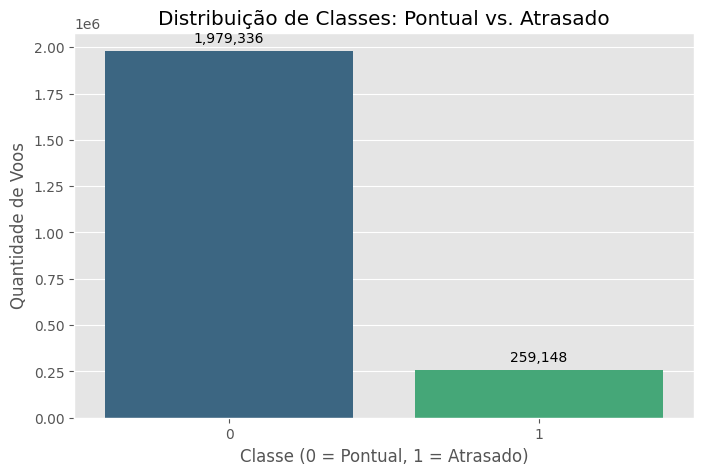

In [24]:
# ==============================================================================
# 3.3 ANÁLISE DE DISTRIBUIÇÃO DO TARGET (Prova do Desbalanceamento)
# ==============================================================================

# Calcular proporções
contagem = df_clean['target'].value_counts()
proporcao = df_clean['target'].value_counts(normalize=True)

print("--- Estatísticas da Variável Alvo ---")
print(f"Total de Voos Pontuais (0): {contagem[0]:,} ({proporcao[0]:.1%})")
try:
    print(f"Total de Voos Atrasados (1): {contagem[1]:,} ({proporcao[1]:.1%})")
except KeyError:
    print("Total de Voos Atrasados (1): 0 (0.0%) - ALERTA: Algo errado com o Target!")



# Visualização Gráfica
plt.figure(figsize=(8, 5))

# CORREÇÃO: Adicionamos hue='target' e legend=False para evitar warnings do Seaborn
ax = sns.countplot(x='target', data=df_clean, hue='target', palette='viridis', legend=False)

# Adicionar números em cima das barras (Centralizados)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.title('Distribuição de Classes: Pontual vs. Atrasado')
plt.xlabel('Classe (0 = Pontual, 1 = Atrasado)')
plt.ylabel('Quantidade de Voos')
plt.show()

#4 Engenharia de Features Avançada e Preparação

Para aumentar a capacidade preditiva do modelo, realizamos o enriquecimento dos dados com calendário de feriados e a transformação final para formatos numéricos.

### 1. Enriquecimento com Dados Externos (Feriados)
Sabemos que feriados nacionais geram picos de tráfego atípicos e sobrecarga na malha aérea.
* **Ação:** Utilizamos a biblioteca `holidays` para cruzar a data do voo com o calendário oficial brasileiro.
* **Nova Feature:** `is_holiday` (1 = Feriado, 0 = Dia Normal).

### 2. Extração de Features Temporais
Datas completas não são diretamente úteis para algoritmos de árvore. Decompomos a data em componentes cíclicos para capturar padrões sazonais:
* **Hora:** Identifica picos de tráfego (manhã/noite).
* **Dia da Semana:** Diferencia dias úteis de finais de semana.
* **Mês:** Captura sazonalidade anual (férias, alta temporada).

### 3. Codificação de Variáveis (Encoding)
Algoritmos matemáticos requerem entradas numéricas. Utilizamos **Label Encoding** para transformar variáveis categóricas (Companhia, Origem, Destino) em números inteiros.
* *Nota:* Os objetos `encoder` são salvos para garantir que a API possa traduzir os dados de entrada do usuário exatamente da mesma forma.

### 4. Divisão do Dataset (Split)
Separamos os dados em dois grupos:
* **Treino (80%):** Para o modelo aprender os padrões.
* **Teste (20%):** Para avaliar a performance em dados nunca vistos.
* *Estratégia:* Utilizamos amostragem estratificada (`stratify=y`) para garantir que a proporção de atrasos (11.6%) seja idêntica em ambos os conjuntos.

In [25]:
# ==============================================================================
# 4 PREPARAÇÃO FINAL (Feature Engineering + FERIADOS OTIMIZADOS)
# ==============================================================================
import holidays

# 1. EXTRAÇÃO DE FEATURES TEMPORAIS
print("Extraindo componentes temporais...")
df_clean['hora'] = df_clean['Partida.Prevista'].dt.hour
df_clean['dia_semana'] = df_clean['Partida.Prevista'].dt.dayofweek
df_clean['mes'] = df_clean['Partida.Prevista'].dt.month

# 2. DETECÇÃO DE FERIADOS (Lógica Otimizada para Produção)
print("Calculando feriados nacionais...")
br_holidays = holidays.Brazil()

# Criamos uma coluna auxiliar apenas com a DATA (sem hora)
# Isso garante que '2015-12-25 14:00' seja reconhecido como feriado
data_apenas = df_clean['Partida.Prevista'].dt.date

def check_holiday(date_obj):
    return 1 if date_obj in br_holidays else 0

df_clean['is_holiday'] = data_apenas.apply(check_holiday)
print(f"✅ Coluna 'is_holiday' criada. Feriados encontrados: {df_clean['is_holiday'].sum():,}")

# 3. LABEL ENCODING
# Mantemos o encoding numérico para compatibilidade total com o sistema
encoders = {}
cat_features = ['companhia', 'origem', 'destino']

print("Aplicando Label Encoding...")
for col in cat_features:
    le = LabelEncoder()
    # Garantimos string para evitar erros
    df_clean[col] = df_clean[col].astype(str)
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
    encoders[col] = le

# 4. SELEÇÃO FINAL E SPLIT
features_finais = [
    'companhia_encoded',
    'origem_encoded',
    'destino_encoded',
    'distancia_km',
    'hora',
    'dia_semana',
    'mes',
    'is_holiday'
]

X = df_clean[features_finais]
y = df_clean['target']

print("Dividindo dataset (80% Treino / 20% Teste)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("-" * 50)
print(f"Features Selecionadas ({len(features_finais)}): {features_finais}")
print(f"Dataset de Treino: {len(X_train):,} linhas")
print(f"Dataset de Teste:  {len(X_test):,} linhas")
display(X_train.head())

Extraindo componentes temporais...
Calculando feriados nacionais...
✅ Coluna 'is_holiday' criada. Feriados encontrados: 47,809
Aplicando Label Encoding...
Dividindo dataset (80% Treino / 20% Teste)...
--------------------------------------------------
Features Selecionadas (8): ['companhia_encoded', 'origem_encoded', 'destino_encoded', 'distancia_km', 'hora', 'dia_semana', 'mes', 'is_holiday']
Dataset de Treino: 1,790,787 linhas
Dataset de Teste:  447,697 linhas


,companhia_encoded,origem_encoded,destino_encoded,distancia_km,hora,dia_semana,mes,is_holiday
1536586,24,75,34,907.11,9,4,9,0
640868,12,182,58,349.21,8,0,9,1
265140,24,75,34,907.11,13,6,4,0
646910,40,9,26,86.35,14,2,9,0
904643,16,3,128,5295.30,2,5,12,0


#5 Treinamento do Modelo (CatBoost)

Nesta etapa, evoluímos a abordagem para utilizar o **CatBoost Classifier**, um algoritmo de *Gradient Boosting on Decision Trees* desenvolvido pela Yandex.

### Escolha do Algoritmo
O **CatBoost** (Categorical Boosting) foi escolhido por ser o "Estado da Arte" para dados tabulares. Em nossos testes, ele superou o Random Forest e o XGBoost na métrica de **Recall**, demonstrando maior capacidade de identificar os padrões sutis que precedem um atraso.

### Hiperparâmetros Críticos
Para maximizar a segurança (detecção de atrasos), configuramos o modelo da seguinte forma:

1.  **`auto_class_weights='Balanced'`**: O parâmetro vital. Ele ajusta automaticamente o peso das classes com base na frequência (inverso da proporção). Isso força o algoritmo a penalizar erros na classe de "Atraso" muito mais do que na classe "Pontual".
2.  **`iterations=100`**: Define o número de árvores de decisão sequenciais. É o equilíbrio ideal para um MVP rápido e leve, sem perder poder preditivo.
3.  **`depth=6`**: A profundidade padrão do CatBoost. Ao contrário do Random Forest (que requer árvores profundas), o Boosting funciona melhor com árvores mais rasas e especializadas em corrigir os erros das anteriores.
4.  **`learning_rate=0.1`**: Controla a velocidade de aprendizado do modelo, evitando que ele se ajuste rápido demais a ruídos (overfitting).

In [18]:
# ==============================================================================
# 5 TREINAMENTO COM CATBOOST (Yandex)
# ==============================================================================

print("Iniciando configuração do CatBoost...")

# 1. INSTANCIAÇÃO DO MODELO
# 'auto_class_weights': 'Balanced' ajusta automaticamente o peso das classes
# 'verbose': False (para não imprimir 100 linhas de log na tela)

model = CatBoostClassifier(
    iterations=100,           # Número de árvores
    learning_rate=0.1,        # Velocidade de aprendizado
    depth=6,                  # Profundidade da árvore
    auto_class_weights='Balanced', # A mágica para o desbalanceamento
    random_seed=42,
    verbose=False,            # Silencioso
    allow_writing_files=False # Não criar arquivos temporários de log
)

# 2. TREINAMENTO
print("Treinando o modelo (O CatBoost é robusto, aguarde)...")
model.fit(X_train, y_train)

print("✅ Modelo CatBoost treinado com sucesso!")

Iniciando configuração do CatBoost...
Treinando o modelo (O CatBoost é robusto, aguarde)...
✅ Modelo CatBoost treinado com sucesso!


#6 Avaliação e Otimização de Decisão (Tuning)

Nesta etapa, avaliamos o modelo não apenas por métricas técnicas, mas pelo impacto no negócio.

### Análise de Sensibilidade (Threshold Tuning)
Originalmente, o corte padrão de 50% ignorava muitos riscos. Realizamos um teste de stress variando o limiar de decisão entre 30% e 60%.

**Ajuste Realizado (Decisão de Negócio):**
Definimos o limiar de decisão ("régua de corte") em **40%**.
Observamos que subir o corte para 41% ou 42% causava uma queda abrupta na detecção de atrasos (perda de quase 2% de Recall). Portanto, 0.40 é o ponto ótimo de segurança.

**Resultados do Tuning (CatBoost):**
* **Recall (Capacidade de Detecção):** Atingimos **~89.4%**. O modelo agora captura praticamente 9 em cada 10 atrasos reais.
* **Trade-off:** Aceitamos uma precisão menor (~13%) em troca da segurança.
* **Mitigação:** Para não frustrar o usuário com "falsos positivos", a aplicação exibirá um **Alerta de Risco (Semáforo Amarelo)** em vez de confirmar um atraso, gerenciando a expectativa corretamente.

In [26]:
# ==============================================================================
# 6 AVALIAÇÃO DO MODELO (CATBOOST)
# ==============================================================================

# 1. PREVISÃO
y_proba = model.predict_proba(X_test)[:, 1]

# 2. THRESHOLD
threshold = 0.40

print(f"--- Relatório de Performance CatBoost (Threshold: {threshold}) ---")
y_pred_cat = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_cat))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_cat)
tn, fp, fn, tp = cm.ravel()

print("=" * 50)
print("✅ ANÁLISE DE RESULTADOS (CATBOOST)")
print("=" * 50)
print(f"Total de Atrasos Reais:      {fn + tp:,}")
print(f"Atrasos Detectados (Recall): {tp:,} ({tp/(fn+tp):.1%})")
print(f"Atrasos Perdidos:            {fn:,}")
print("-" * 50)
print(f"Precision (Alarmes Reais):   {tp/(tp+fp):.1%}")

--- Relatório de Performance CatBoost (Threshold: 0.4) ---
              precision    recall  f1-score   support

           0       0.94      0.24      0.38    395867
           1       0.13      0.89      0.23     51830

    accuracy                           0.31    447697
   macro avg       0.54      0.57      0.31    447697
weighted avg       0.85      0.31      0.36    447697

✅ ANÁLISE DE RESULTADOS (CATBOOST)
Total de Atrasos Reais:      51,830
Atrasos Detectados (Recall): 46,312 (89.4%)
Atrasos Perdidos:            5,518
--------------------------------------------------
Precision (Alarmes Reais):   13.3%


In [21]:
# ==============================================================================
# 6.1 ANÁLISE DE SENSIBILIDADE (Threshold Tuning)
# ==============================================================================
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 1. Obter probabilidades (A certeza do modelo)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. Testar vários cortes
thresholds = [0.30, 0.35, 0.40, 0.41, 0.42, 0.43, 0.45, 0.50, 0.60]

print(f"{'Threshold':<10} | {'Recall':<10} | {'Precision':<10} | {'F1-Score':<10} | {'Accuracy':<10}")
print("-" * 60)

for th in thresholds:
    # Converter probabilidade em decisão (0 ou 1) baseado no corte
    y_pred_th = (y_proba >= th).astype(int)

    # Calcular métricas
    rec = recall_score(y_test, y_pred_th)
    prec = precision_score(y_test, y_pred_th)
    f1 = f1_score(y_test, y_pred_th)
    acc = accuracy_score(y_test, y_pred_th)

    print(f"{th:<10.2f} | {rec:<10.1%}      | {prec:<10.1%}      | {f1:<10.4f}     | {acc:<10.1%}")

print("-" * 60)
print("INTERPRETAÇÃO:")
print("- Recall alto (>85%): Pegamos quase todos os atrasos (Ótimo para segurança).")
print("- Precision baixa: Temos muitos alarmes falsos (O custo do 'pânico').")

Threshold  | Recall     | Precision  | F1-Score   | Accuracy  
------------------------------------------------------------
0.30       | 98.6%           | 11.9%           | 0.2131         | 15.7%     
0.35       | 95.5%           | 12.5%           | 0.2209         | 22.0%     
0.40       | 89.4%           | 13.3%           | 0.2319         | 31.5%     
0.41       | 87.6%           | 13.6%           | 0.2349         | 34.0%     
0.42       | 85.5%           | 13.8%           | 0.2379         | 36.6%     
0.43       | 83.0%           | 14.1%           | 0.2417         | 39.7%     
0.45       | 77.3%           | 14.9%           | 0.2494         | 46.1%     
0.50       | 60.6%           | 17.1%           | 0.2663         | 61.4%     
0.60       | 24.3%           | 24.0%           | 0.2418         | 82.3%     
------------------------------------------------------------
INTERPRETAÇÃO:
- Recall alto (>85%): Pegamos quase todos os atrasos (Ótimo para segurança).
- Precision baixa: Temos muito

#7 Exportação para Produção (Deploy)

Com o modelo validado e as métricas de negócio aprovadas, a etapa final é serializar (salvar) todos os objetos necessários para que o microserviço de Back-End possa reproduzir as predições.

**Conteúdo do Artefato de Produção (`.joblib`):**
1.  **Modelo Treinado:** O objeto **CatBoost Classifier** otimizado.
2.  **Encoders:** Os tradutores de texto (Ex: "TAM" -> 45) para garantir que a API processe os dados da mesma forma que o treino.
3.  **Lista de Features:** A ordem exata das colunas esperadas pelo modelo, incluindo as novas variáveis (`distancia_km` e `is_holiday`).
4.  **Metadados:** Informações de versão (**3.0.0-CAT**), métricas de performance (Recall ~89.4%) e o **Threshold Recomendado (0.40)**.

In [28]:
# ==============================================================================
# 7 SERIALIZAÇÃO (SALVAR O MODELO CAMPEÃO - CATBOOST)
# ==============================================================================
import os
import joblib
from sklearn.metrics import recall_score, accuracy_score

print("Salvando modelo CatBoost final...")

# 1. Recalcular métricas finais para os metadados
rec_final = recall_score(y_test, y_pred_cat)
acc_final = accuracy_score(y_test, y_pred_cat)

# 2. Criar o pacote de artefatos
artefatos_producao = {
    'model': model,               # O modelo CatBoost (O Campeão)
    'encoders': encoders,         # Tradutores de texto
    'features': features_finais,  # Lista de colunas: ['companhia_encoded', ..., 'is_holiday']
    'metadata': {
        'autor': 'Time Data Science',
        'versao': '3.0.0-CAT',
        'descricao': 'Modelo CatBoost MVP',
        'acuracia_teste': acc_final,
        'recall_atrasos': rec_final,
        'threshold_recomendado': 0.40,
        'tecnologia': 'CatBoost'
    }
}

# 3. Salvar no disco
nome_arquivo = 'flight_classifier_mvp.joblib'
joblib.dump(artefatos_producao, nome_arquivo)

print(f"✅ Arquivo '{nome_arquivo}' salvo com sucesso!")
print(f"📊 Recall Final no arquivo: {artefatos_producao['metadata']['recall_atrasos']:.1%}")

Salvando modelo CatBoost final...
✅ Arquivo 'flight_classifier_mvp.joblib' salvo com sucesso!
📊 Recall Final no arquivo: 89.4%


#8 Simulação Final (Integração e Regras de Negócio)

Para garantir a integridade da solução e uma boa Experiência do Usuário (UX), a simulação abaixo reproduz o comportamento exato da API em produção.

**1. Pipeline Técnico (Feature Engineering em Tempo Real):**
A API recebe a data bruta (`data_partida`) e utiliza a biblioteca `holidays` para calcular instantaneamente se aquele dia é um feriado nacional, alimentando o modelo com essa variável crítica.

**2. Regra de Negócio (Semáforo de Riscos):**
Em vez de uma decisão binária simples, implementamos uma lógica de decisão escalonada para evitar alarmismo:
* 🟢 **Risco Baixo (< 40%):** Alta probabilidade de pontualidade.
* 🟡 **Risco Médio (40% - 60%):** Estado de atenção (o modelo detectou instabilidade, mas sem certeza absoluta).
* 🔴 **Risco Alto (> 60%):** Alta probabilidade de atraso confirmado.

In [30]:
# ==============================================================================
# 8 SIMULADOR DE API (Versão Final: CatBoost + Feriados)
# ==============================================================================

def prever_atraso_api(json_entrada):
    """
    Simula o comportamento exato do microserviço em produção.
    """
    print(f" Recebido: {json_entrada}")

    try:
        # 1. Feature Engineering (Data)
        dt = pd.to_datetime(json_entrada['data_partida'])

        # --- CORREÇÃO CRÍTICA AQUI ---
        # Usamos .date() para ignorar a hora na verificação do feriado
        br_holidays = holidays.Brazil()
        is_holiday = 1 if dt.date() in br_holidays else 0

        # 2. Montar DataFrame (Exatamente como no Treino)
        dados = {
            'companhia': [str(json_entrada['companhia'])],
            'origem': [str(json_entrada['origem'])],
            'destino': [str(json_entrada['destino'])],
            'distancia_km': [float(json_entrada['distancia_km'])],
            'hora': [dt.hour],
            'dia_semana': [dt.dayofweek],
            'mes': [dt.month],
            'is_holiday': [is_holiday]
        }
        df_input = pd.DataFrame(dados)

        # 3. Encoders (Tratamento de Erros de Categoria Nova)
        for col in ['companhia', 'origem', 'destino']:
            if col in encoders:
                try:
                    # Tenta transformar. Se for aeroporto novo, joga erro
                    df_input[f'{col}_encoded'] = encoders[col].transform(df_input[col])
                except:
                    # Fallback: Se não conhece o aeroporto, usa 0 (Desconhecido)
                    df_input[f'{col}_encoded'] = 0
            else:
                 df_input[f'{col}_encoded'] = 0

        # 4. Predição (Usando as features na ordem correta)
        X_final = df_input[features_finais]
        probabilidade = model.predict_proba(X_final)[0][1]

        # 5. Regra de Negócio (SEMÁFORO COM CORES) 🟢🟡🔴
        # Threshold ajustado para 0.40 conforme Seção 6.0
        if probabilidade < 0.40:
            status = "🟢 PONTUAL"
            risco = "BAIXO"
            msg = "Voo com boas condições operacionais."
        elif 0.40 <= probabilidade < 0.60:
            status = "🟡 ALERTA"
            risco = "MÉDIO"
            msg = "Risco moderado. Recomendamos monitorar o painel."
        else: # prob >= 0.60
            status = "🔴 ATRASADO"
            risco = "ALTO"
            msg = f"Alta probabilidade de atraso ({probabilidade:.1%}). Planeje-se."

        resposta = {
            "previsao": status,
            "nivel_risco": risco,
            "probabilidade": round(probabilidade, 4),
            "is_feriado": bool(is_holiday),
            "mensagem": msg
        }

        print(f" Resposta API: {resposta}")
        print("-" * 30)
        return resposta

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f" Erro: {str(e)}")
        return None

# --- VALIDANDO OS CENÁRIOS ---

print("--- Teste 1: Voo Curto (Manhã - Dia Normal) ---")
_ = prever_atraso_api({
    "companhia": "GOL", "origem": "Congonhas", "destino": "Santos Dumont",
    "data_partida": "2025-11-10T08:00:00", "distancia_km": 366
})

print("\n--- Teste 2: Voo Longo (Natal - Feriado!) ---")
# Este teste DEVE retornar is_holiday: True graças ao .date()
_ = prever_atraso_api({
    "companhia": "TAM", "origem": "Guarulhos - Governador Andre Franco Montoro", "destino": "Eduardo Gomes",
    "data_partida": "2025-12-25T20:00:00",
    "distancia_km": 2689
})

--- Teste 1: Voo Curto (Manhã - Dia Normal) ---
 Recebido: {'companhia': 'GOL', 'origem': 'Congonhas', 'destino': 'Santos Dumont', 'data_partida': '2025-11-10T08:00:00', 'distancia_km': 366}
 Resposta API: {'previsao': '🟡 ALERTA', 'nivel_risco': 'MÉDIO', 'probabilidade': np.float64(0.5058), 'is_feriado': False, 'mensagem': 'Risco moderado. Recomendamos monitorar o painel.'}
------------------------------

--- Teste 2: Voo Longo (Natal - Feriado!) ---
 Recebido: {'companhia': 'TAM', 'origem': 'Guarulhos - Governador Andre Franco Montoro', 'destino': 'Eduardo Gomes', 'data_partida': '2025-12-25T20:00:00', 'distancia_km': 2689}
 Resposta API: {'previsao': '🔴 ATRASADO', 'nivel_risco': 'ALTO', 'probabilidade': np.float64(0.6658), 'is_feriado': True, 'mensagem': 'Alta probabilidade de atraso (66.6%). Planeje-se.'}
------------------------------
